In [ ]:
PRESSURE_DERIV_WINDOW = "1h"    # Derivative derivation window
DROP_THRESHOLD = -1.5           # hPa per window
RISE_THRESHOLD =  1.5           # hPa per window
GAP_THRESHOLD = "2min"          # Threshold for identifying data gaps
DAYS = 30                       # Time period over which to report

In [59]:
%run pathutils.ipynb
%run database.ipynb
%run export.ipynb

In [60]:
import pandas as pd

def extract_front_events(mask, tendency):
    events = []
    in_event = False
    start = None
    peak_time = None
    peak_value = None
    
    for ts, is_event in mask.items():
        if is_event and not in_event:
            # start of event
            in_event = True
            start = ts
            peak_time = ts
            peak_value = tendency.loc[ts]
            
        elif is_event and in_event:
            # update peak intensity
            if tendency.loc[ts] < peak_value:   # for drops: more negative = stronger
                peak_value = tendency.loc[ts]
                peak_time = ts
                
        elif not is_event and in_event:
            # event ends
            end = ts
            events.append({
                'start': start,
                'end': end,
                'peak_time': peak_time,
                'peak_change': peak_value
            })
            in_event = False
    
    # close if still ongoing
    if in_event:
        end = mask.index[-1]
        events.append({
            'start': start,
            'end': end,
            'peak_time': peak_time,
            'peak_change': peak_value
        })

    # Convert to a data frame and make sure the dates and times don't have timezone information associate with them
    df = pd.DataFrame(events)
    df["start"] = (
        pd.to_datetime(df["start"], utc=True)       # ensure datetime with tz
        .dt.tz_convert(None)                        # drop timezone
    )

    df["end"] = (
        pd.to_datetime(df["end"], utc=True)         # ensure datetime with tz
        .dt.tz_convert(None)                        # drop timezone
    )

    df["peak_time"] = (
        pd.to_datetime(df["peak_time"], utc=True)   # ensure datetime with tz
        .dt.tz_convert(None)                        # drop timezone
    )

    return df

In [ ]:
# Load the readings for each sensor and produce a combined data frame
bme280_df = load_sensor_readings("bme280", DAYS)
veml7700_df = load_sensor_readings("veml7700", DAYS)
sgp40_df = load_sensor_readings("sgp40", DAYS)
combined_df = merge_sensor_readings([bme280_df, veml7700_df, sgp40_df])
combined_df.head()

,temperature,pressure,humidity,als,illuminance,issaturated,sraw,vocindex,label,rating
timestamp,,,,,,,,,,
2025-12-06 16:07:21+00:00,21.81,991.985000,41.365234,20,1.1520,0,30754,0,Excellent,*****
2025-12-06 16:08:23+00:00,21.80,992.060039,41.467773,82,4.7232,0,30778,40,Excellent,*****
2025-12-06 16:09:26+00:00,21.79,991.988828,41.557617,78,4.4928,0,30795,95,Good,****
2025-12-06 16:10:28+00:00,21.78,992.075117,41.510742,62,3.5712,0,30806,97,Good,****
2025-12-06 16:11:30+00:00,21.76,992.078984,41.601562,90,2.5920,0,30821,98,Good,****


In [62]:
import numpy as np

# Calculate pressure derivative over the window
combined_df['pressure_change'] = combined_df['pressure'].diff()
combined_df['pressure_change_hr'] = combined_df['pressure'].diff().rolling(PRESSURE_DERIV_WINDOW).sum()

# Detect rapid drops and rises
combined_df['front_low']  = combined_df['pressure_change_hr'] < DROP_THRESHOLD
combined_df['front_high'] = combined_df['pressure_change_hr'] > RISE_THRESHOLD

combined_df['front_low'] = (
    combined_df['front_low']
      .astype(float)
      .rolling(3, center=True)
      .max()
      .fillna(0)
      .astype(bool)
)

combined_df['front_high'] = (
    combined_df['front_high']
      .astype(float)
      .rolling(3, center=True)
      .max()
      .fillna(0)
      .astype(bool)
)

# Detect weather front events
low_fronts = extract_front_events(combined_df['front_low'], combined_df['pressure_change_hr'])
high_fronts = extract_front_events(combined_df['front_high'], combined_df['pressure_change_hr'])

# Smooth the data for plotting
combined_df['pressure_smooth'] = combined_df['pressure'].rolling('30min', center=True).mean()
combined_df['pressure_change_smooth'] = combined_df['pressure_change_hr'].rolling('1h', center=True).mean()

# Calculate the time delta between samples and identify gaps larger than expected
combined_df['dt'] = pd.to_timedelta(combined_df.index.diff(), errors='coerce')
combined_df['is_gap'] = combined_df['dt'] > pd.Timedelta(GAP_THRESHOLD)

display(combined_df.head())

# Create a gaps dataframe
gaps = combined_df[combined_df['is_gap']].copy()
if not gaps.empty:
    gaps["gap_end"] = gaps.index

    prev_index = combined_df.index.to_series().shift(1)

    # Robust: align by index, guaranteed Series of timestamps (or NaT)
    gaps["gap_start"] = prev_index.reindex(gaps.index)

    # Make sure both are proper UTC-aware datetimes
    gaps["gap_start"] = pd.to_datetime(gaps["gap_start"], utc=True)
    gaps["gap_end"]   = pd.to_datetime(gaps["gap_end"],   utc=True)

# For each gap, mask values inside the interval with NaN so matplotlib won't draw lines across gaps
for _, row in gaps.iterrows():
  mask = (combined_df.index >= row["gap_start"]) & (combined_df.index <= row["gap_end"])
  combined_df.loc[mask, "pressure_smooth"] = np.nan
  combined_df.loc[mask, "pressure_change_smooth"] = np.nan

,temperature,pressure,humidity,als,illuminance,issaturated,sraw,vocindex,label,rating,pressure_change,pressure_change_hr,front_low,front_high,pressure_smooth,pressure_change_smooth,dt,is_gap
timestamp,,,,,,,,,,,,,,,,,,
2025-12-06 16:07:21+00:00,21.81,991.985000,41.365234,20,1.1520,0,30754,0,Excellent,*****,NaN,NaN,False,False,992.103057,0.178973,NaT,False
2025-12-06 16:08:23+00:00,21.80,992.060039,41.467773,82,4.7232,0,30778,40,Excellent,*****,0.075039,0.075039,False,False,992.108125,0.182947,0 days 00:01:02,False
2025-12-06 16:09:26+00:00,21.79,991.988828,41.557617,78,4.4928,0,30795,95,Good,****,-0.071211,0.003828,False,False,992.112125,0.186773,0 days 00:01:03,False
2025-12-06 16:10:28+00:00,21.78,992.075117,41.510742,62,3.5712,0,30806,97,Good,****,0.086289,0.090117,False,False,992.115432,0.193393,0 days 00:01:02,False
2025-12-06 16:11:30+00:00,21.76,992.078984,41.601562,90,2.5920,0,30821,98,Good,****,0.003867,0.093984,False,False,992.115267,0.195292,0 days 00:01:02,False


In [63]:
# Get the export folder path
export_folder_path = get_export_folder_path()

display(low_fronts.head())

# Strip the timezone from the timestamp, as this will cause the export to spreadsheet to fail (Excel can't
# handle dates with timezone information)
combined_df.index = combined_df.index.tz_localize(None)

# Export the data to a spreadsheet
export_to_spreadsheet(export_folder_path, "pressure-event.xlsx", {
    "Data": combined_df,
    "Low Pressure Events": low_fronts,
    "High Pressure Events": high_fronts
})

,start,end,peak_time,peak_change
0,2025-12-07 12:15:26,2025-12-07 12:30:59,2025-12-07 12:17:31,-1.535820
1,2025-12-07 12:36:10,2025-12-07 15:00:07,2025-12-07 12:37:43,-1.846484
2,2025-12-08 22:13:50,2025-12-09 06:30:16,2025-12-08 22:15:15,-6.026914


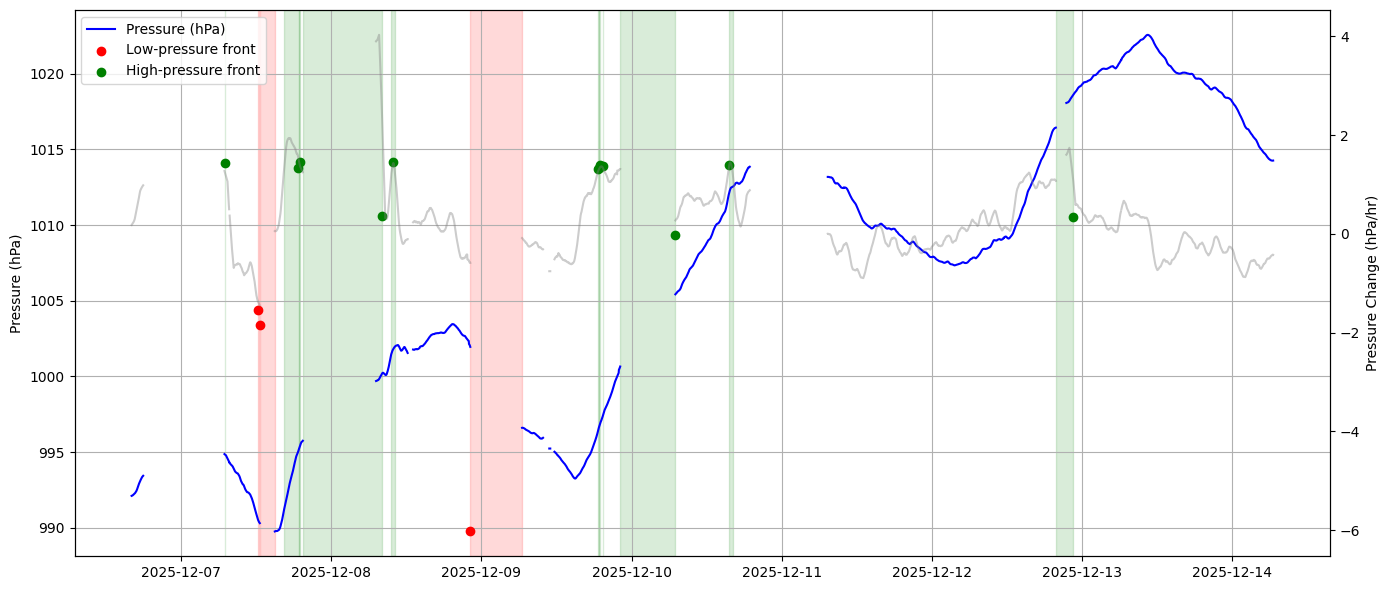

In [64]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14, 6))

# Left axis: pressure (blue)
ax1.plot(combined_df.index, combined_df['pressure_smooth'], color='blue', label='Pressure (hPa)')
ax1.set_ylabel("Pressure (hPa)")
ax1.grid(True)

# Right axis: pressure-change (red/green)
ax2 = ax1.twinx()
ax2.set_ylabel("Pressure Change (hPa/hr)")

# Plot pressure tendency
ax2.plot(combined_df.index, combined_df['pressure_change_smooth'], color='gray', alpha=0.4)

# Add peaks — note they now use ax2
ax2.scatter(low_fronts['peak_time'], 
            low_fronts['peak_change'], 
            color='red', 
            label='Low-pressure front')

ax2.scatter(high_fronts['peak_time'], 
            high_fronts['peak_change'], 
            color='green', 
            label='High-pressure front')

# Add shaded areas across both axes
for _, evt in low_fronts.iterrows():
    ax1.axvspan(evt['start'], evt['end'], color='red', alpha=0.15)

for _, evt in high_fronts.iterrows():
    ax1.axvspan(evt['start'], evt['end'], color='green', alpha=0.15)

# Legend handling
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()

# Export to PNG or PDF, if required
export_chart(export_folder_path, "pressure-event", "png")

plt.show()